### Лабораторная работа №3

Выполнила Карасева Екатерина M33351

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_percentage_error

# Меня ждут миллионы

Обучите простую модель предсказания цены акций. Используйте один из рассмотренных на лекции "Временные последовательности" алгоритмов предсказания рядов. Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 

    Найти данные можно на kaggle или использовать FAANG датасет из 1 лабораторной
    * Выбранные данные: [FAANG Historical Stock Price Data](https://www.kaggle.com/specter7/amazon-amzn-historical-stock-price-data) - данные о биржевых котировках компаний FAANG c 2016 по 2021 год. Facebook.

In [2]:
df = pd.read_csv('Facebook_Historical_StockPrice2.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,113.320000,114.589996,112.949997,113.690002,113.690002,21351800
1,2016-03-29,113.830002,116.320000,113.639999,116.139999,116.139999,29825300
2,2016-03-30,116.730003,116.989998,114.360001,114.699997,114.699997,33235200
3,2016-03-31,114.699997,115.010002,113.769997,114.099998,114.099998,21207500
4,2016-04-01,113.750000,116.169998,113.349998,116.059998,116.059998,24760500


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам

In [3]:
df['Month'] = df['Date'].str[:-3]
df = df.loc[df['Month'].between('2016-04', '2021-02')].groupby('Month').agg({
    'High': lambda x: max(x)
})
df.head()

,High
Month,
2016-04,120.790001
2016-05,121.080002
2016-06,119.440002
2016-07,128.330002
2016-08,126.730003


  Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы

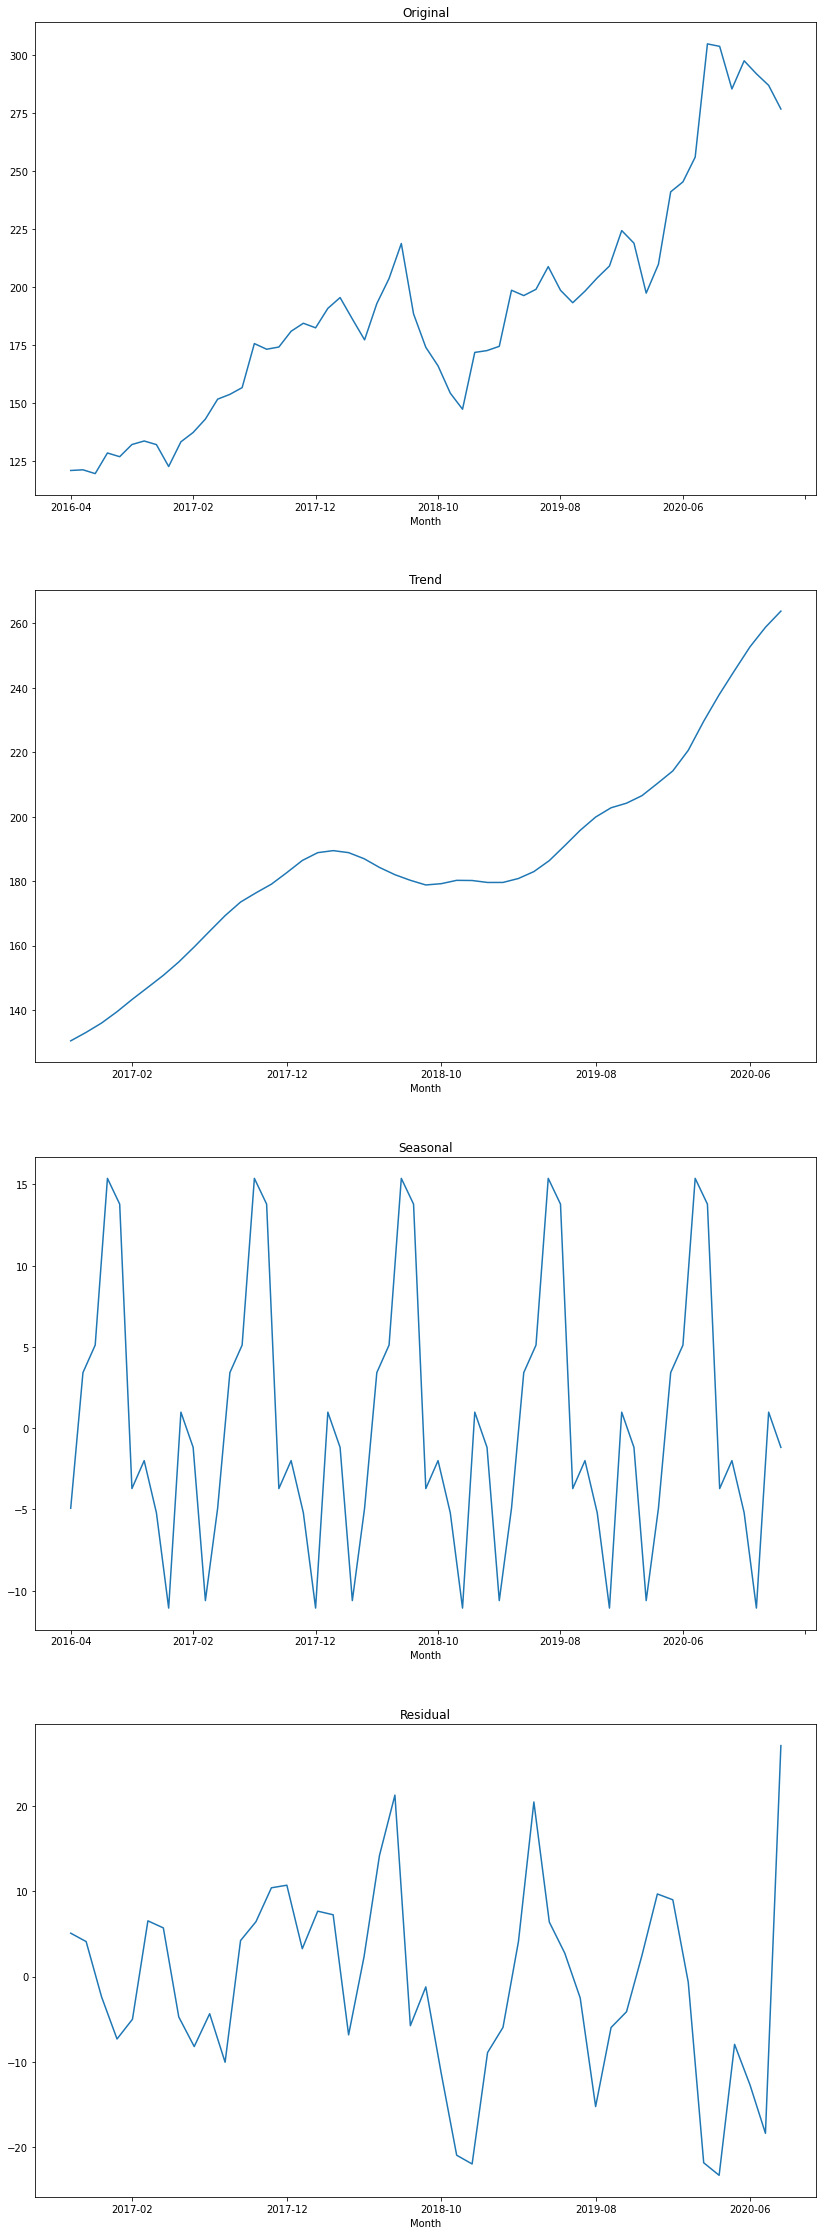

In [4]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df[['High']], period=12)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

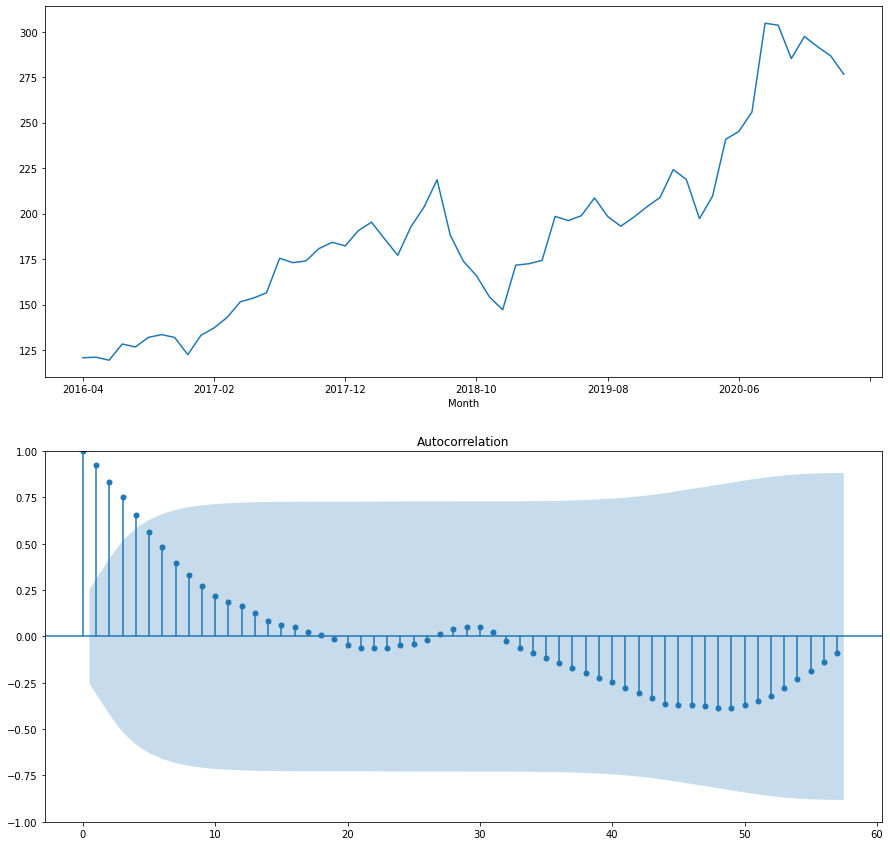

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df['High'].plot(ax=ax[0])
plot_acf(df['High'], lags=df['High'].size - 2, ax=ax[1]);

In [6]:
p_value = adfuller(df['High'])[1]
print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной!'
)

Полученный уровень значимости (p-value): 0.7467. 0.7467 > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной!


In [7]:
df['HighLog'] = np.log(df['High'])
df['HighLogDiff_1'] = df['HighLog'].diff()
df.head(8)

,High,HighLog,HighLogDiff_1
Month,,,
2016-04,120.790001,4.794054,NaN
2016-05,121.080002,4.796451,0.002398
2016-06,119.440002,4.782814,-0.013637
2016-07,128.330002,4.854605,0.071791
2016-08,126.730003,4.842059,-0.012546
2016-09,131.979996,4.882650,0.040591
2016-10,133.500000,4.894101,0.011451
2016-11,131.940002,4.882347,-0.011754


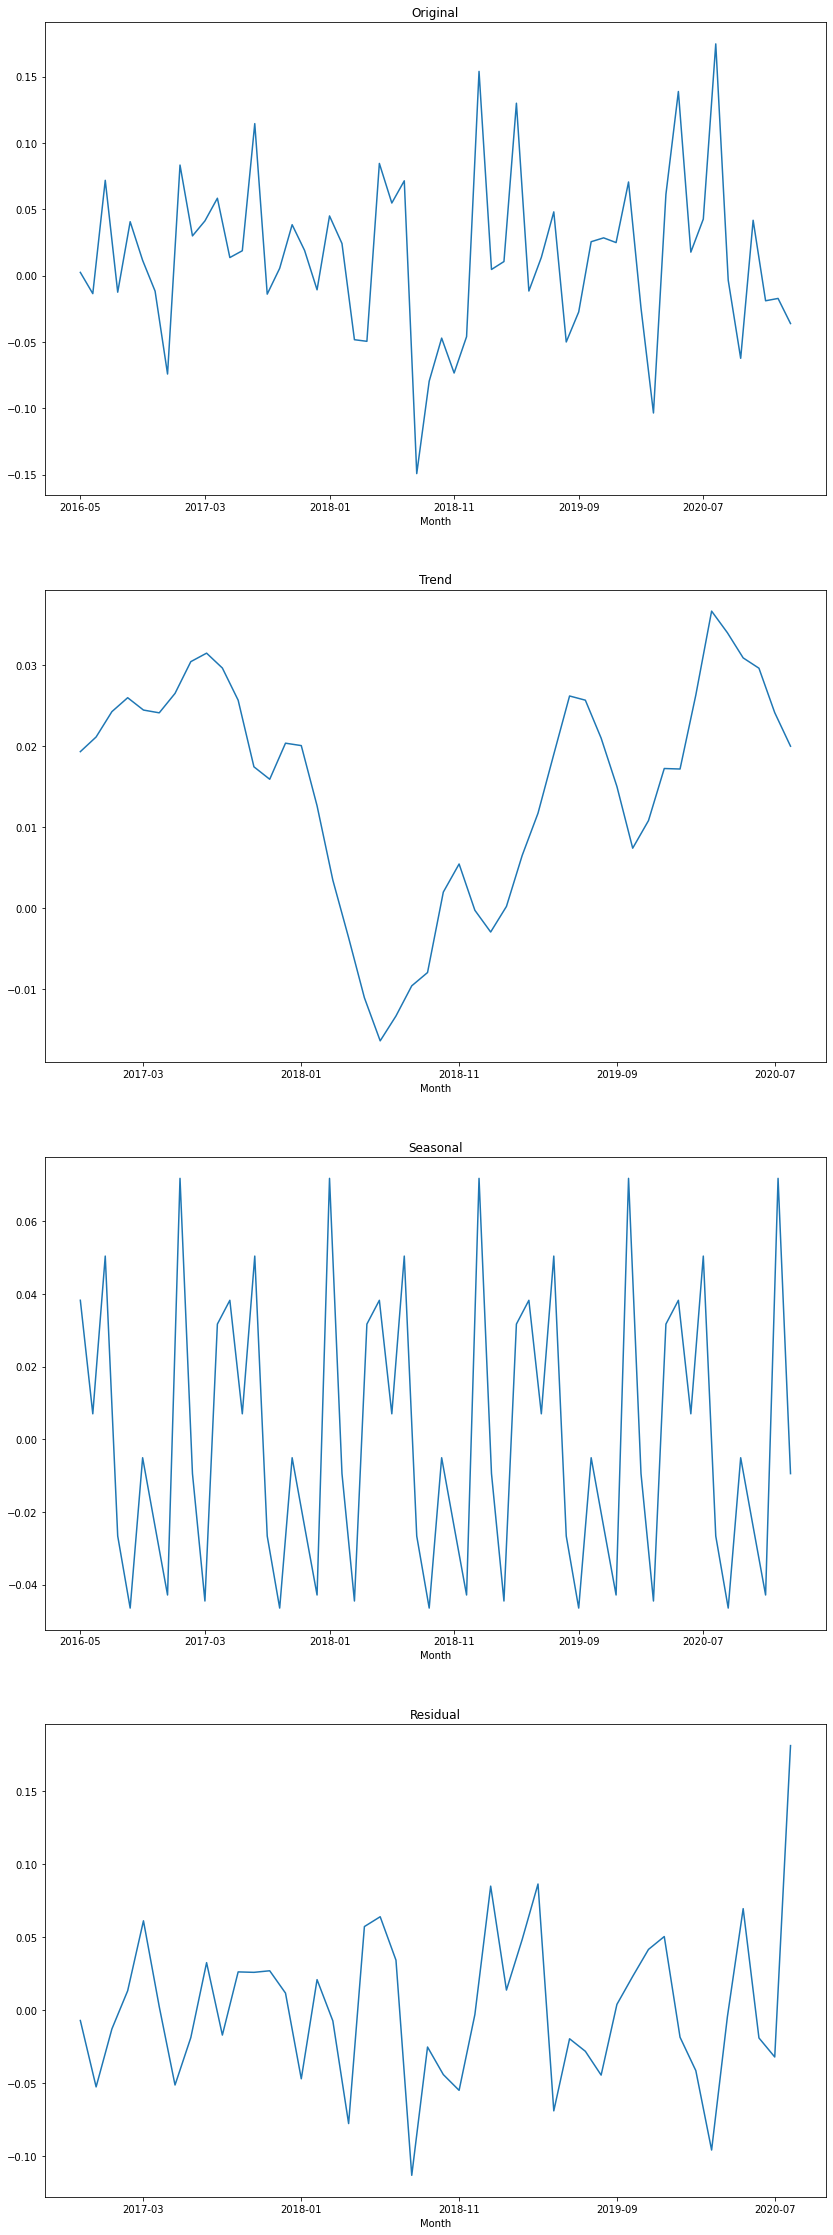

In [8]:
df2 = df.drop(index='2016-04')

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df2[['HighLogDiff_1']], period=12)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

In [9]:
p_value = adfuller(df['HighLogDiff_1'][1:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)

Полученный уровень значимости (p-value): 0.0003. 0.0003 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


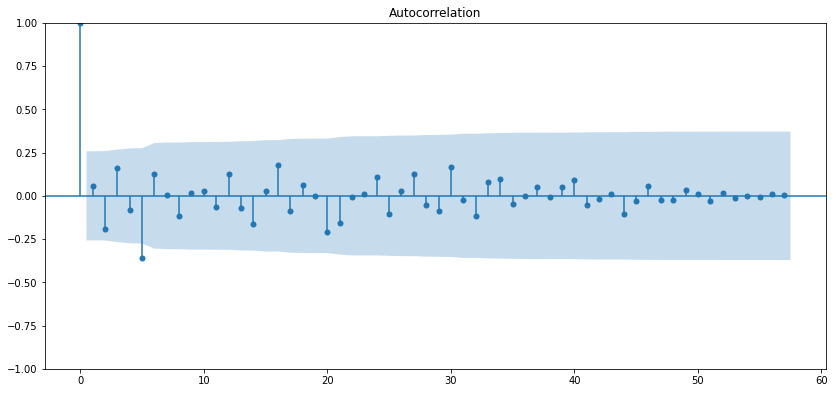

In [10]:
plt.figure(figsize=(14, 14))

ax = plt.subplot(212)
plot_acf(df['HighLogDiff_1'][1:], lags=df['HighLogDiff_1'].size - 2, ax=ax);

3. Обучите модель

    Обучите модель на 80% временного ряда
    
    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью модели 

In [11]:
d=1
D=1

qs = range(1, 5)
Qs = range(1, 3)

ps = range(1, 5)
Ps = range(3, 5)

from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# выбор 80% данных для обучения
train_size = round((df['HighLog'].size - 2) * 0.8)
train_size

46

In [12]:
%%time
#warnings.filterwarnings('ignore')
import statsmodels.api as sm


results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            df['HighLog'][:train_size],
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 12)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

#warnings.filterwarnings('default')

  0%|          | 0/64 [00:00<?, ?it/s]D:\study\5sem\DA\lab3\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\study\5sem\DA\lab3\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\study\5sem\DA\lab3\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  2%|▏         | 1/64 [00:01<01:45,  1.67s/it]D:\study\5sem\DA\lab3\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used

Wall time: 5min 47s


In [13]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            HighLog   No. Observations:                   46
Model:             SARIMAX(1, 1, 1)x(3, 1, 1, 12)   Log Likelihood                  48.614
Date:                            Wed, 15 Dec 2021   AIC                            -83.228
Time:                                    18:01:06   BIC                            -72.753
Sample:                                04-01-2016   HQIC                           -79.704
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0296      0.533      0.056      0.956      -1.016       1.075
ma.L1          0.3462      0.525   

In [14]:
predicted_values = best_model.predict(start=train_size + 1, end=df['HighLog'].size).to_frame()
predicted_values.index = predicted_values.index.strftime('%Y-%m')
df['Predicted'] = np.exp(predicted_values)
df

,High,HighLog,HighLogDiff_1,Predicted
Month,,,,
2016-04,120.790001,4.794054,NaN,NaN
2016-05,121.080002,4.796451,0.002398,NaN
2016-06,119.440002,4.782814,-0.013637,NaN
2016-07,128.330002,4.854605,0.071791,NaN
2016-08,126.730003,4.842059,-0.012546,NaN
2016-09,131.979996,4.882650,0.040591,NaN
2016-10,133.500000,4.894101,0.011451,NaN
2016-11,131.940002,4.882347,-0.011754,NaN
2016-12,122.500000,4.808111,-0.074236,NaN


    Отобразите на графике предсказание модели и истинные данные

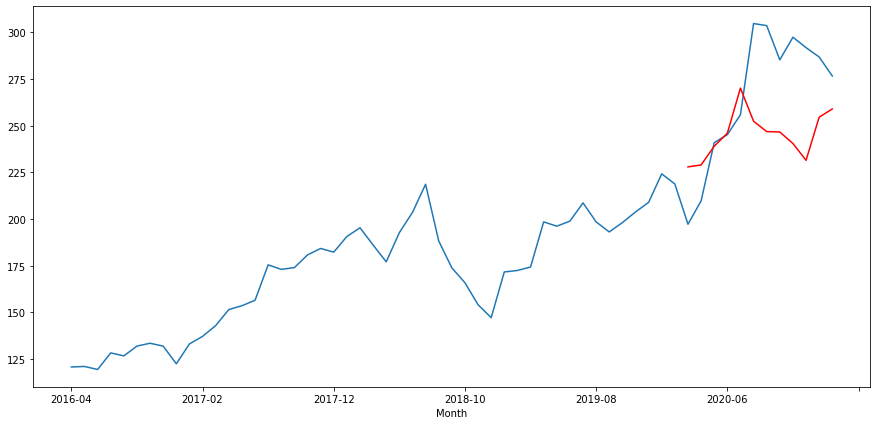

In [15]:
plt.figure(figsize=(15,7))
df['High'].plot()
df['Predicted'].plot(c='r');

4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

In [16]:
mape = mean_absolute_percentage_error(df['High'][train_size + 1:], df['Predicted'][train_size + 1:])
print("MAPE: " + str(mape))


MAPE: 0.11522324807357404
